In [4]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability as tfp
from sklearn.linear_model import LinearRegression
import pandas as pd
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0
TF  Version 2.0.0-alpha0


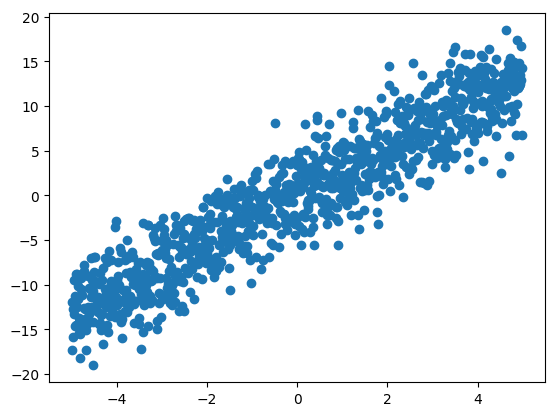

In [6]:
x=np.arange(-5,5,0.01)#x range
np.random.seed(52)
noise=np.random.normal(loc=0,scale=3,size=len(x))# const var
y=2.7*x+noise #y linear model with const var
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))
plt.scatter(x,y)

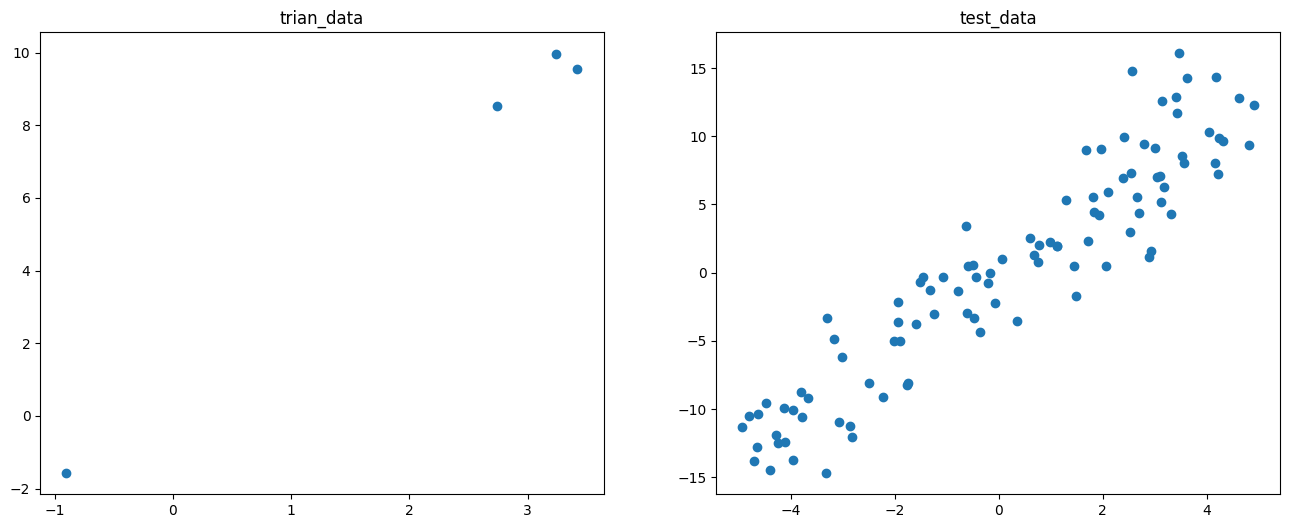

In [7]:
train_idx=np.random.choice(range(0,len(x)),4,replace=False)# sample 4 trainpoints
test_range=np.delete(range(0,len(x)),train_idx)
test_idx=np.random.choice(test_range,100,replace=False)# sample 100 testpoints, without the 4 from train
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x[train_idx],y[train_idx])
plt.title("trian_data")
plt.subplot(1,2,2)
plt.scatter(x[test_idx],y[test_idx])
plt.title("test_data")
plt.show()

In [8]:
model_skl = LinearRegression()
res = model_skl.fit(x[train_idx], y[train_idx])
a_ml = res.coef_
b_ml = res.intercept_
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml)

Coefficients a_ml:  [2.69022907] Coefficients b_ml [0.90367888]


In [9]:
# Calculation of the the optimal sigma 
y_hat_train = model_skl.predict(x[train_idx])
n = len(y_hat_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(x[train_idx] - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_skl.predict(x[test_idx]) #Prediction on the testset
NLL_skl =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y[test_idx] - y_hat.flatten())**2)/sigma_hat_2
NLL_skl


Estimated variance  41.01895007782419
Estimated standart deviation  6.404603818958998


4.315819977907475

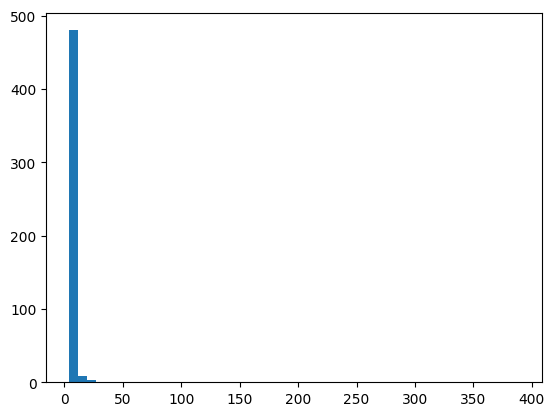

mean : 6.395072239552191
median : 3.982342409424894


In [10]:
from tqdm import tqdm_notebook as tqdm

NLL=np.empty(0)
for i in tqdm(range(0,500)):
  train_idx=np.random.choice(range(0,len(x)),4,replace=False)# sample 4 trainpoints
  test_range=np.delete(range(0,len(x)),train_idx)
  test_idx=np.random.choice(test_range,100,replace=False)# sample 100 testpoints, without the 4 from train
  model_skl = LinearRegression()
  res = model_skl.fit(x[train_idx], y[train_idx])
  y_hat_train = model_skl.predict(x[train_idx])
  n = len(y_hat_train)
  sigma_hat_2 = (n-1.)/(n-2.) * np.var(x[train_idx] - y_hat_train.flatten(),ddof=1)
  y_hat = model_skl.predict(x[test_idx]) #Prediction on the testset
  NLL_sample =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y[test_idx] - y_hat.flatten())**2)/sigma_hat_2
  NLL=np.append(NLL,NLL_sample)
plt.hist(NLL,bins=50)
plt.show()
print("mean :",np.mean(NLL))
print("median :",np.median(NLL))

In [0]:
sigma=3

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
ytensor = y[train_idx].reshape([len(y[train_idx]),1]) #A
def log_post_unnorm(w): #B
    rv_a = tfd.Normal(loc=0., scale=1.) #C 
    rv_b = tfd.Normal(loc=0., scale=1.) #C    
    y_prob = tfd.Independent( #D
        tfd.Normal(loc=x[train_idx]*w[0]+w[1], scale=sigma)
    )
    return (
         tf.reduce_sum(#E
             tf.reduce_sum(y_prob.log_prob(ytensor))+
             rv_a.log_prob(w[0])+ 
             rv_b.log_prob(w[1]))
    )
#A y is now a 2-dimensional tensor
#B w holds the two random variables a=w[0] and b=w[1] in the Tensor w
#C This is the prior for the slope and intercept
#D Definition of the likelihood (independent Gaussian with fixed sigma)
#E Calculation of the log-posterior as defined in eq.log_post

In [24]:
w = tf.Variable([[0.0],[0.0]],dtype=tf.float32) #Startvalues
for e in range(1000):
    with tf.GradientTape() as tape: 
        loss = -log_post_unnorm(w)
        grads = tape.gradient(loss, w)
        w = tf.Variable(w - 0.01*grads)
a_max_post = w[0].numpy()[0]
b_max_post = w[1].numpy()[0]
print("Maximum A-Posterior a", a_max_post, " b ", b_max_post)


y_hat_train = a_max_post+x[train_idx]+b_max_post
n = len(y_hat_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(x[train_idx] - y_hat_train.flatten(),ddof=1)
y_hat = a_max_post+x[test_idx]+b_max_post
NLL_sample =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y[test_idx] - y_hat.flatten())**2)/sigma_hat_2

Maximum A-Posterior a 2.749407  b  0.41614607


3.7719145389409077

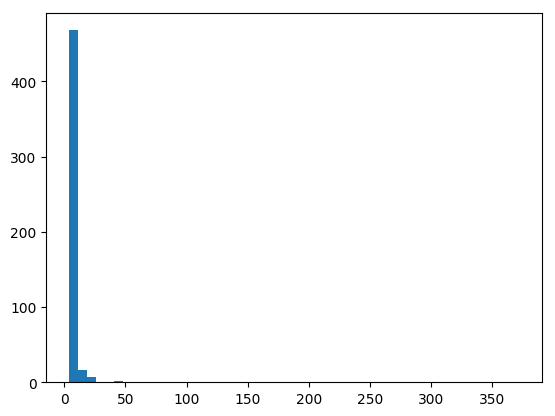

mean : 7.749007635239911
median : 4.520301550957334


In [27]:
from tqdm import tqdm_notebook as tqdm

NLL=np.empty(0)
for i in tqdm(range(0,500)):
  train_idx=np.random.choice(range(0,len(x)),4,replace=False)# sample 4 trainpoints
  test_range=np.delete(range(0,len(x)),train_idx)
  test_idx=np.random.choice(test_range,100,replace=False)# sample 100 testpoints, without the 4 from train
  w = tf.Variable([[0.0],[0.0]],dtype=tf.float32) #Startvalues
  for e in range(600):
      with tf.GradientTape() as tape: 
          loss = -log_post_unnorm(w)
          grads = tape.gradient(loss, w)
          w = tf.Variable(w - 0.01*grads)
  a_max_post = w[0].numpy()[0]
  b_max_post = w[1].numpy()[0]
  y_hat_train = a_max_post+x[train_idx]+b_max_post
  n = len(y_hat_train)
  sigma_hat_2 = (n-1.)/(n-2.) * np.var(x[train_idx] - y_hat_train.flatten(),ddof=1)
  y_hat = a_max_post+x[test_idx]+b_max_post
  NLL_sample =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y[test_idx] - y_hat.flatten())**2)/sigma_hat_2
  NLL=np.append(NLL,NLL_sample)
plt.hist(NLL,bins=50)
plt.show()
print("mean :",np.mean(NLL))
print("median :",np.median(NLL))

In [106]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)

def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(inputs)
dist = tfp.layers.DistributionLambda(my_dist)(params) 


model = Model(inputs=inputs, outputs=dist)
model.compile(Adam(), loss=NLL) 
model.summary()

Model: "model_573"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_572 (InputLayer)       [(None, 1)]               0         
_________________________________________________________________
dense_flipout_564 (DenseFlip (None, 2)                 8         
_________________________________________________________________
distribution_lambda_571 (Dis ((None, 1), (None, 1))    0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(x[train_idx],y[train_idx],batch_size=4,epochs=6000,verbose=0)

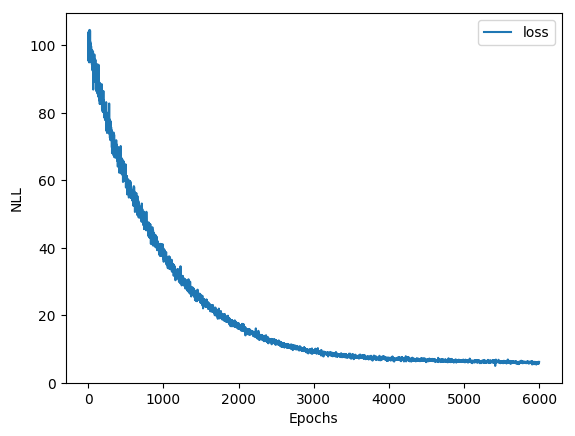

In [108]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [109]:
model.evaluate(x[test_idx],y[test_idx],verbose=0)


22.617652587890625

In [0]:
model_mean= Model(inputs=inputs, outputs=dist.mean())

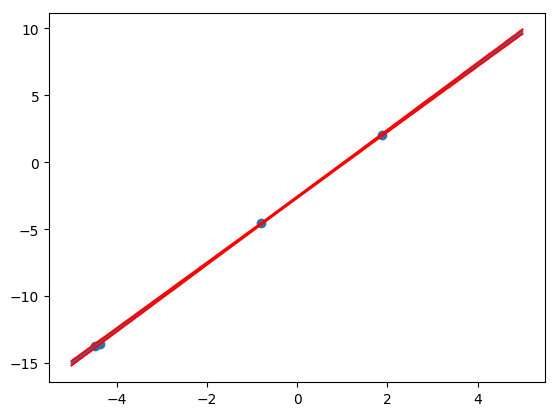

In [111]:
test=np.array([model_mean.predict(x) for i in range(0,500)])
test=test.reshape(500,1000)
pred=np.mean(test,axis=0).reshape((1000,1))
pred_sd=np.std(test,axis=0).reshape((1000,1))
plt.plot(x,pred)
plt.plot(x,pred+pred_sd,c="r")
plt.plot(x,pred-pred_sd,c="r")
plt.scatter(x[train_idx],model_mean.predict(x)[train_idx])
#plt.scatter(x,model_mean.predict(x))
#plt.scatter(x[train_idx],model_mean.predict(x)[train_idx])

In [60]:
x.shape

(1000, 1)

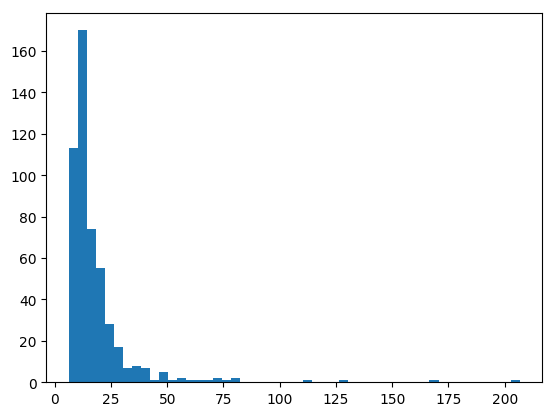

mean : 17.812031967582705
median : 12.946387615203857


In [32]:
from tqdm import tqdm_notebook as tqdm

NLL_bayes=np.empty(0)
for i in tqdm(range(0,500)):
  train_idx=np.random.choice(range(0,len(x)),4,replace=False)# sample 4 trainpoints
  test_range=np.delete(range(0,len(x)),train_idx)
  test_idx=np.random.choice(test_range,100,replace=False)# sample 100 testpoints, without the 4 from train
  
  inputs = Input(shape=(1,))
  params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(inputs)
  dist = tfp.layers.DistributionLambda(my_dist)(params) 
  model = Model(inputs=inputs, outputs=dist)
  model.compile(Adam(), loss=NLL) 
  model.fit(x[train_idx],y[train_idx],batch_size=4,epochs=6000,verbose=0)

  NLL_sample =  model.evaluate(x[test_idx],y[test_idx],verbose=0)
  NLL_bayes=np.append(NLL_bayes,NLL_sample)
plt.hist(NLL_bayes,bins=50)
plt.show()
print("mean :",np.mean(NLL_bayes))
print("median :",np.median(NLL_bayes))

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#123456789012345678901234567890123456789012345678901234
def NLL(y, distr):#C
    return -distr.log_prob(y) 
    
def my_dist(mu): #C
    return tfd.Normal(loc=mu[:,0:1], scale=3)

divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0]* 1.0) #B



inputs = Input(shape=(1,))

params = tfp.layers.DenseReparameterization(1,
        kernel_divergence_fn=divergence_fn,
        bias_divergence_fn=divergence_fn, #A
        bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,#A
        bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn())(inputs)
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model = Model(inputs=inputs, outputs=dist)




sgd = tf.keras.optimizers.SGD(lr=.005)
model.compile(loss=NLL, optimizer=sgd)

In [79]:
model.summary()

Model: "model_571"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_571 (InputLayer)       [(None, 1)]               0         
_________________________________________________________________
dense_reparameterization_7 ( (None, 1)                 4         
_________________________________________________________________
distribution_lambda_570 (Dis ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(x[train_idx],y[train_idx],batch_size=4,epochs=6000,verbose=0)

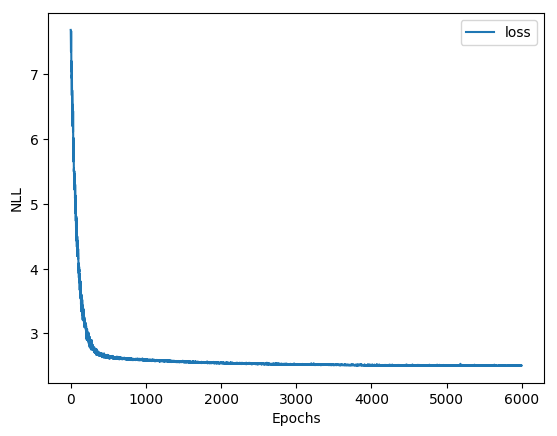

In [81]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [82]:
model.evaluate(x[test_idx],y[test_idx],verbose=0)


3.157497138977051

In [0]:
model_mean= Model(inputs=inputs, outputs=dist.mean())

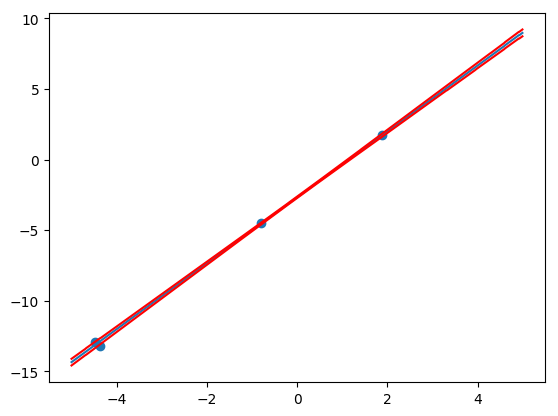

In [105]:
test=np.array([model_mean.predict(x) for i in range(0,500)])
test=test.reshape(500,1000)
pred=np.mean(test,axis=0).reshape((1000,1))
pred_sd=np.std(test,axis=0).reshape((1000,1))
plt.plot(x,pred)
plt.plot(x,pred+pred_sd,c="r")
plt.plot(x,pred-pred_sd,c="r")
plt.scatter(x[train_idx],model_mean.predict(x)[train_idx])